## MULTILAYER PERCEPTRON MODEL WITH RUL LIMITATION
This notebook presents de coding to build the Multilayer Perceptron Model with the RUL limition and the implementation over FD001.

In [1]:
## Load basic libraries

from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 
import random
random.seed(123)

#model_path = 'MLP_regression_PCA_FD1_tuned.h5'




In [2]:
##Load data science libraries

import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
import keras.backend as Kback
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from math import e
from Perform_function import perform_func





Using TensorFlow backend.


In [3]:
##Data loading

train_df = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/train_FD001.txt", delimiter = ',')
test_df  = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/test_FD001.txt", delimiter = ',')
RUL_test = pd.read_csv("C:/Users/eduardo.tadeo/OneDrive - INVENSITY GmbH/Master Thesis/Master Thesis/Datasets/CMAPSSData/RUL_FD001.txt")
RUL_real = RUL_test

In [4]:
#######
##Data ingestion & processing
######

#Unuseful columns deleting 

train_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)

test_df.drop(['T_EGT', 'SmFan', 'SmLPC', 'SmHPC'], axis = 1, inplace = True)


###TRAIN DATA SET###

# Standarization for sensor variables 

train_df['Cycle_norm'] = train_df['Cycle']
cols_normalize = train_df.columns.difference(['Unit','Cycle','UL','RUL','UL_30','UL_50', 'UL_75'])
scaler = StandardScaler()
scaled_train = scaler.fit_transform(train_df[cols_normalize])
norm_train_df = pd.DataFrame(scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

# Principal Component Analysis Dimensionality Reduction

pca = PCA(.95)

pca.fit(norm_train_df)
transformed_train = pca.transform(scaled_train)

df_transformed_train = pd.DataFrame(transformed_train, index = train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(df_transformed_train)
train_df = join_df.reindex()


# Data labeling - Remaining Useful LIfe (RUL) --> Time to failure

RUL = pd.DataFrame(train_df.groupby('Unit')['Cycle'].max()).reset_index()
RUL.columns = ['Unit','UL']
train_df = train_df.merge(RUL, on = ['Unit'], how = 'left')
train_df['RUL'] = train_df['UL'] - train_df['Cycle']




In [5]:
###TEST DATA SET###


# Standarization for sensor variables
test_df['Cycle_norm'] = test_df['Cycle']
norm_test_df = pd.DataFrame(scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

print(norm_train_df.shape,norm_test_df.shape)

# Principal Component Analysis Dimensionality Reduction

transformed_test = pca.transform(norm_test_df)

df_transformed_test = pd.DataFrame(transformed_test, index = test_df.index)

join_df = test_df[test_df.columns.difference(cols_normalize)].join(df_transformed_test)
test_df = join_df.reindex()

# We use the ground truth dataset to generate labels for the test data.
# Generate column max for test data
rul = pd.DataFrame(test_df.groupby('Unit')['Cycle'].max()).reset_index()
rul.columns = ['Unit', 'max']
RUL_test.columns = ['more']
RUL_test['Unit'] = RUL_test.index + 1
RUL_test['max'] = rul['max'] + RUL_test['more']
RUL_test.drop('more', axis=1, inplace=True)

# Generate RUL for test data
test_df = test_df.merge(RUL_test, on=['Unit'], how='left')
test_df['RUL'] = test_df['max'] - test_df['Cycle']
#test_df.drop('max', axis=1, inplace=True)



(20631, 25) (13096, 25)


In [6]:
## Model dataset preparation ###

train_cols = list(train_df.columns[2:-2].values)

train_all = train_df[train_cols]

train = train_df
X_train = train[train_cols].to_numpy()
Y_train = train['RUL'].to_numpy()
#print(Y_train[:200])

Y_tuned = np.zeros(Y_train.shape)

Y_tuned[:] = Y_train

Y_tuned[Y_tuned>145] = 145

## Prepare the test dataset to predict the RUL on the last cycle of every turbine's useful life.


test_proof = pd.DataFrame([test_df[test_df['Unit']==id].iloc[-1,:]
                for id in test_df['Unit'].unique()]).reset_index(drop = True)

test_proof.drop(['max'], axis = 1, inplace = True)





In [7]:
## Hyperparameters

# Here the hyperparameters of the model are defined


n_neurons_first = 20 # Number of neurons in the input layer
n_neurons_hidden = 20 # Number of neurons in the hidden layer
n_hidden_layers = 5 # Number of hidden layers

dim = X_train.shape[1]


In [8]:
# Additional metrics to be implemented in the model

def r2_keras(y_true, y_pred): 
    ##Coefficient of Determination##

    SS_res = Kback.sum(Kback.square(y_true - y_pred))
    SS_tot = Kback.sum(Kback.square( y_true - Kback.mean(y_true)))
    return (1 - SS_res/(SS_tot + Kback.epsilon()))

def Computed_Score(y_true, y_pred):
    ##Computed score used in the challenge

    a1 = 10
    a2 = 13
    score = 0
    d = y_pred - y_true

    score_vec = np.zeros(len(y_true))

    for i in range(len(d)): 
        if d[i]<0:
            score_vec[i] = (e**(-d[i]/a1) - 1)
            score += score_vec[i]
        else : 
            score_vec[i] = (e**(d[i]/a2) - 1)
            score += score_vec[i]

    fig_hist = plt.figure(figsize=(10,5))
    plt.hist(score_vec, color = "#3f729a" )
    hist_data, _, _ = plt.hist(score_vec, color = "#3f729a" )
    print(hist_data)
    plt.ylabel("Frequency")
    plt.xlabel("Score")

    score_low = 0
    score_high = 0

    for i in range(len(d)):

        if score_vec[i] < 50:
            score_low += score_vec[i]
        else:
            score_high += score_vec[i]

    

    print(score_low, score_high)
    print(score_low/(score_low + score_high))

    plt.figure()
    plt.plot(range(100),score_vec)

    return score


In [9]:
## Model building

# The Multilayer Perceptron Model is built according to the hyperparameters configuration

model_MLP = Sequential()

model_MLP.add(Dense(
    n_neurons_first, 
    input_dim = dim,
    kernel_initializer = 'glorot_normal', 
    activation = 'relu'))
model_MLP.add(Dropout(0.2))

for i in range(n_hidden_layers):
    model_MLP.add(Dense(n_neurons_hidden, kernel_initializer = 'glorot_normal', activation = 'relu'))
    model_MLP.add(Dropout(0.2))

model_MLP.add(Dense(1, kernel_initializer = 'glorot_normal'))

model_MLP.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = [r2_keras,'mae'] )

print(model_MLP.summary())

result = model_MLP.fit(X_train, Y_tuned, epochs = 100, batch_size = 5, verbose = 1, 
    validation_split = 0.05, 
    callbacks = [keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0, patience=15, verbose = 0, mode = 'min'), 
        keras.callbacks.ModelCheckpoint(model_path, monitor = 'val_loss', save_best_only = True, mode = 'min', verbose = 0)])
        
print(result.history.keys())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                280       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)               

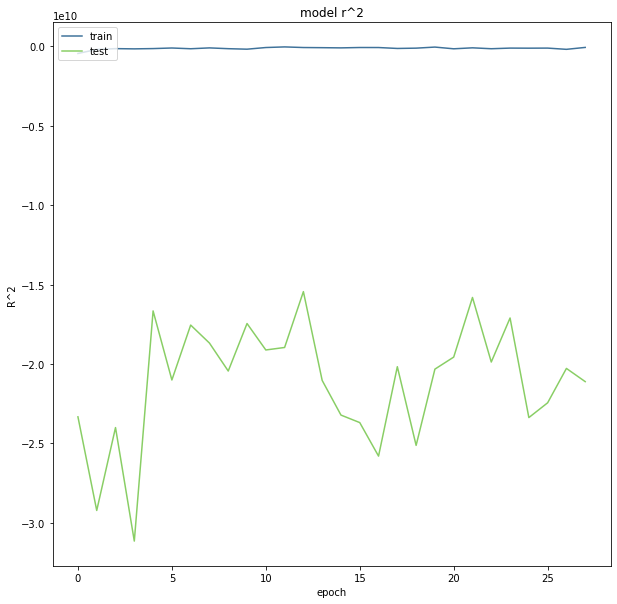

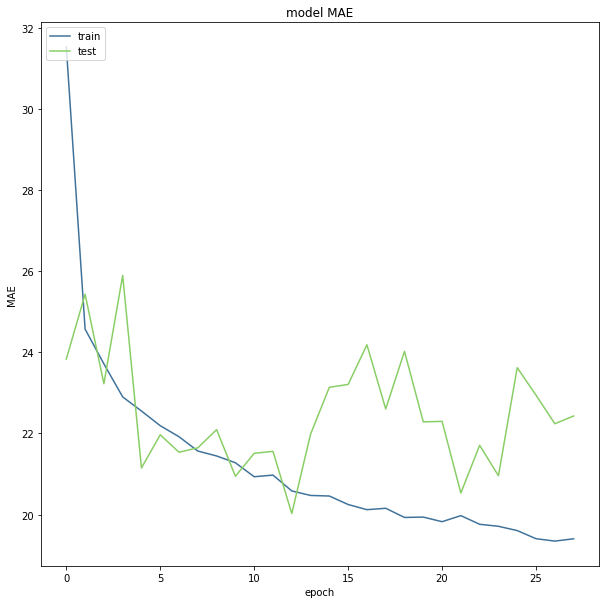

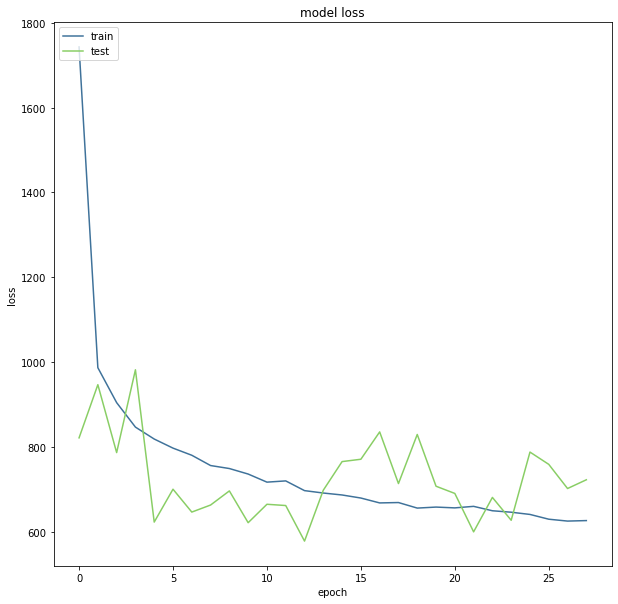

In [10]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['r2_keras'], color="#3f729a")
plt.plot(result.history['val_r2_keras'], color="#89ce65")
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['mae'], color="#3f729a")
plt.plot(result.history['val_mae'], color="#89ce65")
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(result.history['loss'], color="#3f729a")
plt.plot(result.history['val_loss'], color="#89ce65")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#fig_acc.savefig("model_regression_loss.png")

In [11]:
predictions = model_MLP.predict(train_all)

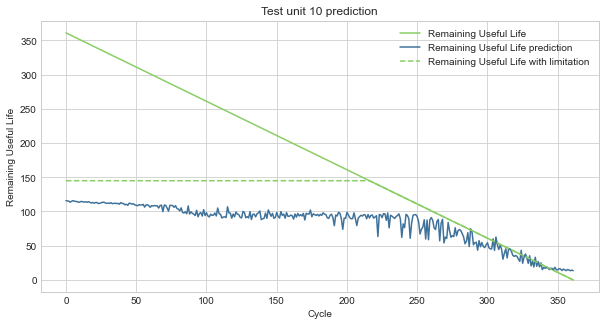

In [25]:
## Model predictions for the train se

train_df['RUL_predict'] = predictions

unit = 69

plt.style.use('seaborn-whitegrid')
fig = plt.figure(figsize = (10,5))

ax = fig.add_subplot(111)

ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL'], color = "#89ce65", label = "Remaining Useful Life")
ax.plot(range(len(train_df[train_df['Unit']==unit])), Y_tuned[train_df.loc[train_df['Unit']==unit,:].index], color ="#89ce65", label = "Remaining Useful Life with limitation", linestyle = '--')
ax.plot(range(len(train_df[train_df['Unit']==unit])), train_df[train_df['Unit']==unit]['RUL_predict'], color ="#3f729a", label = "Remaining Useful Life prediction")


ax.set_ylabel("Remaining Useful Life")
ax.set_xlabel("Cycle")
ax.set_title("Test unit 10 prediction")

ax.legend()





MAE: 0.7971811890602112

R^2: 13.381111145019531
[[120.18611 ]
 [115.65941 ]
 [ 63.472443]
 [ 88.91225 ]
 [ 92.36046 ]
 [ 94.07854 ]
 [ 98.552475]
 [ 70.5748  ]
 [115.515686]
 [ 95.31618 ]
 [ 92.01599 ]
 [ 99.75557 ]
 [ 88.932816]
 [116.33241 ]
 [114.70378 ]
 [ 97.78819 ]
 [ 48.539646]
 [ 52.38284 ]
 [ 87.68441 ]
 [ 24.976475]
 [ 69.8045  ]
 [117.10855 ]
 [102.068115]
 [ 26.418015]
 [116.8248  ]
 [103.14618 ]
 [ 86.338234]
 [ 80.92633 ]
 [ 94.49166 ]
 [ 74.39162 ]
 [ 18.093063]
 [ 48.614536]
 [114.883804]
 [ 16.536915]
 [ 15.620909]
 [ 25.942894]
 [ 49.131306]
 [ 45.26292 ]
 [118.657745]
 [ 26.879246]
 [ 55.081326]
 [ 19.679125]
 [ 58.85095 ]
 [115.145584]
 [ 67.65581 ]
 [ 48.87779 ]
 [113.75194 ]
 [103.056206]
 [ 23.043571]
 [108.10752 ]
 [ 79.57472 ]
 [ 29.644379]
 [ 30.26101 ]
 [113.21106 ]
 [ 98.86018 ]
 [ 22.645718]
 [ 72.189575]
 [ 36.885708]
 [115.06993 ]
 [ 83.38477 ]
 [ 31.847881]
 [ 64.23547 ]
 [ 54.374435]
 [ 34.40662 ]
 [116.89484 ]
 [ 18.516113]
 [114.35008 ]
 [ 17.68935 

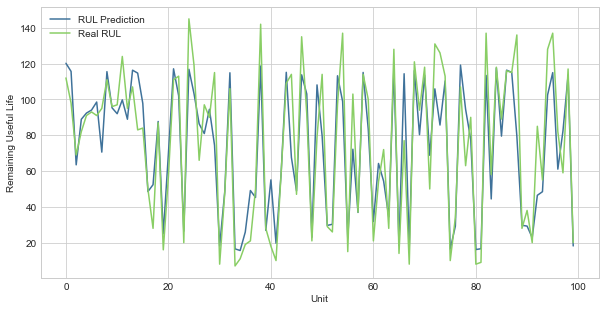

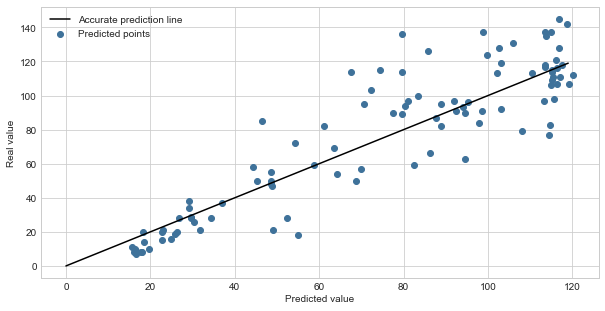

In [13]:
## Model evaluation - Part 1

if os.path.isfile(model_path):
    
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(test_proof[train_cols], test_proof['RUL'].to_numpy(), verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(test_proof[train_cols])
    y_true_test = test_proof['RUL'].to_numpy()

    print(y_pred_test)
    print(y_true_test)

    #test_set = pd.DataFrame(y_pred_test)
    #test_set.to_csv('submit_test.csv', index = None)

    plt.style.use('seaborn-whitegrid')

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, color="#3f729a")
    plt.plot(y_true_test, color="#89ce65")
    plt.ylabel('Remaining Useful Life')
    plt.xlabel('Unit')
    plt.legend(['RUL Prediction', 'Real RUL'], loc='best')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

    #Plot the results

    fig_predict = plt.figure(figsize = (10,5))
    plt.scatter(y_pred_test, y_true_test, color = "#3f729a")
    plt.plot(range(y_pred_test.max().astype(int)),range(y_pred_test.max().astype(int)), color = "black")
    plt.ylabel('Real value')
    plt.xlabel('Predicted value')
    plt.legend(['Accurate prediction line', 'Predicted points'])
    plt.show()


[93.  4.  1.  1.  0.  0.  0.  0.  0.  1.]
402.9544731796652 493.72033773406304
0.4493875240780402


896.6748109137278

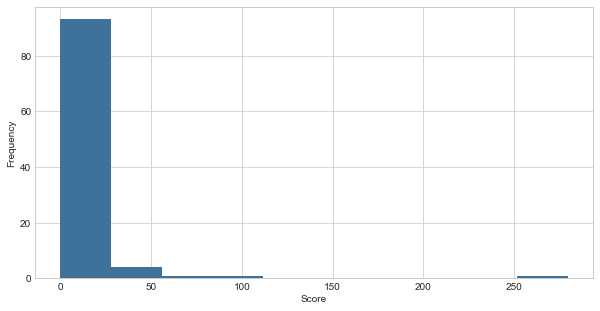

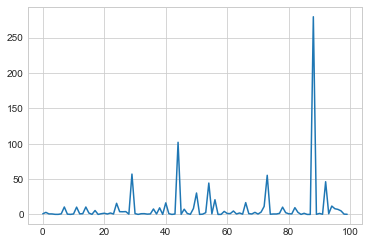

In [14]:
## Challenge score analysis

Computed_Score(y_true_test, y_pred_test[:,0])

The model score is: 896.6748109137283
The model accuracy is: 57.0
The model MAE is: 13.381111221313477
The model MSE is : 327.77796375755725
The model Mean Absolute Percentage Error (MAPE) is: 21.5974323469063
The model Mean Absolute Percentage Error 2 (MAPE_2) is: 4.735542123091317


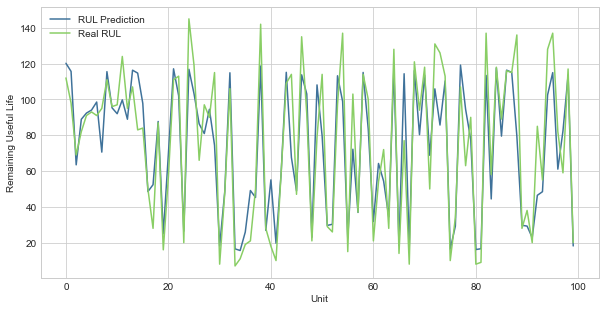

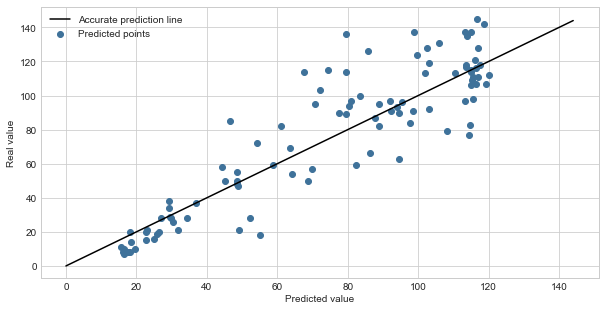

(896.6748109137283,
 57.0,
 13.381111221313477,
 327.77796375755725,
 21.5974323469063,
 4.735542123091317)

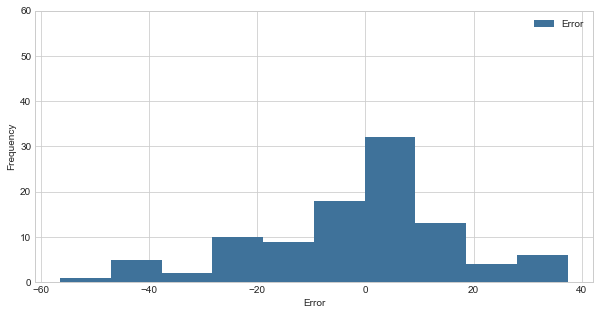

In [15]:
## Model evaluation - Part 2

perform_func(y_pred_test[:,0], y_true_test, test_df.groupby('Unit').max()['max'].to_numpy())


In [16]:
## Error analysis by differencing the RUL to predict and the information we have about the turbine

error_df = pd.DataFrame()
error_df[['Unit','Cycle','RUL']] = test_proof[['Unit','Cycle','RUL']]
error_df['error'] =  np.abs(y_pred_test[:,0] - y_true_test)

error_df['Group'] = 0
error_df.loc[error_df['Cycle'] <= 20, 'Group'] = 1
error_df.loc[(error_df['Cycle'] <= 40) & (error_df['Cycle'] > 20) , 'Group'] = 2
error_df.loc[(error_df['Cycle'] <= 60) & (error_df['Cycle'] > 40) , 'Group'] = 3
error_df.loc[(error_df['Cycle'] <= 80) & (error_df['Cycle'] > 60) , 'Group'] = 4
error_df.loc[(error_df['Cycle'] <= 100) & (error_df['Cycle'] > 80) , 'Group'] = 5
error_df.loc[(error_df['Cycle'] <= 120) & (error_df['Cycle'] > 100) , 'Group'] = 6
error_df.loc[(error_df['Cycle'] <= 140) & (error_df['Cycle'] > 120) , 'Group'] = 7
error_df.loc[(error_df['Cycle'] > 140) , 'Group'] = 8

error_df['Group_RUL'] = 0
error_df.loc[error_df['RUL'] <= 20, 'Group_RUL'] = 1
error_df.loc[(error_df['RUL'] <= 40) & (error_df['RUL'] > 20) , 'Group_RUL'] = 2
error_df.loc[(error_df['RUL'] <= 60) & (error_df['RUL'] > 40) , 'Group_RUL'] = 3
error_df.loc[(error_df['RUL'] <= 80) & (error_df['RUL'] > 60) , 'Group_RUL'] = 4
error_df.loc[(error_df['RUL'] <= 100) & (error_df['RUL'] > 80) , 'Group_RUL'] = 5
error_df.loc[(error_df['RUL'] <= 120) & (error_df['RUL'] > 100) , 'Group_RUL'] = 6
error_df.loc[(error_df['RUL'] <= 140) & (error_df['RUL'] > 120) , 'Group_RUL'] = 7
error_df.loc[(error_df['RUL'] > 140) , 'Group_RUL'] = 8

In [17]:
error_grouped  = error_df.groupby('Group').mean()

error_grouped_RUL = error_df.groupby('Group_RUL').mean()

error_grouped

,Unit,Cycle,RUL,error,Group_RUL
Group,,,,,
2,36.750000,35.250000,120.750000,9.517483,6.500000
3,35.375000,51.500000,114.125000,9.997377,6.250000
4,58.000000,72.727273,108.181818,17.976671,5.727273
5,62.857143,92.285714,113.857143,8.721921,6.000000
6,45.571429,108.571429,97.000000,17.999767,5.428571
7,50.388889,129.888889,59.611111,15.895815,3.444444
8,51.466667,177.755556,53.711111,12.203163,3.088889


In [18]:
error_grouped_RUL

,Unit,Cycle,RUL,error,Group
Group_RUL,,,,,
1,55.250000,173.125000,13.312500,8.874396,7.812500
2,57.500000,174.000000,28.250000,7.764474,7.750000
3,55.181818,153.636364,53.363636,8.561328,7.636364
4,48.166667,111.166667,71.000000,23.571922,6.000000
5,34.590909,133.000000,91.272727,12.565361,6.590909
6,49.850000,82.850000,112.600000,12.342768,4.550000
7,68.909091,110.272727,130.909091,26.593655,5.454545
8,32.000000,42.500000,143.500000,25.758728,2.500000


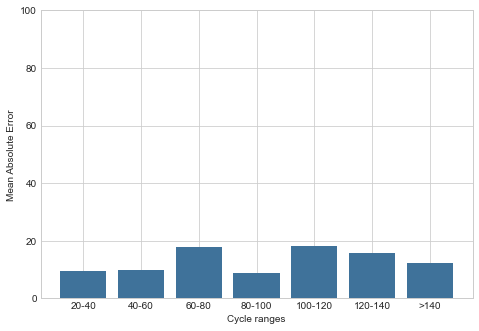

In [19]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Cycle ranges")
plt.ylim(0,100)
plt.show()


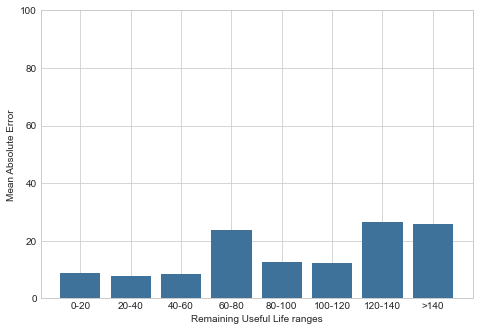

In [20]:
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
ratios = ['0-20','20-40', '40-60', '60-80', '80-100', '100-120','120-140', '>140']
errors = error_grouped_RUL['error']
ax.bar(ratios,errors,color="#3f729a")
plt.ylabel("Mean Absolute Error")
plt.xlabel("Remaining Useful Life ranges")
plt.ylim(0, 60)
plt.show()
